# (Project Proposal Title)

## Introduction

(Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal)

(Clearly state the question you will try to answer with your project)

(Identify and describe the dataset that will be used to answer the question)

## Preliminary Exploratory Data Analysis

In [8]:
library(tidyverse)
library(tidymodels)
# amsterdam, athens, barcelona, berlin, budapest, lisbon, london, paris, rome, vienna
# weekdays, weekends
# just doing a practice run
amsterdam_weekdays <- read_csv("https://zenodo.org/record/4446043/files/amsterdam_weekdays.csv")

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

New names:
• `` -> `...1`
Rows: 1103 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): 

In [9]:
# clean data
amsterdam_weekdays_clean <- amsterdam_weekdays |>
    select(-1) |>
# according to https://zenodo.org/record/4446043#.Y9Y9ENJBwUE these columns are dummies:
    select(-room_private, -room_shared) |>
# apparently these are already scaled to [0,100] - drop the duplicate
    select(-attr_index, -rest_index) |>
    mutate(room_type = as_factor(room_type)) |>
    rename(dist_from_city_centre = dist,
           cost = realSum,
           attraction_index = attr_index_norm,
           restaurant_index = rest_index_norm)

amsterdam_weekdays_clean |>
    select(room_type) |>
    pull() |>
    levels()

glimpse(amsterdam_weekdays_clean)

[1] "Private room"    "Entire home/apt" "Shared room"

Rows: 1,103
Columns: 15
$ cost                       <dbl> 194.0337, 344.2458, 264.1014, 433.5294, 485…
$ room_type                  <fct> Private room, Private room, Private room, P…
$ person_capacity            <dbl> 2, 4, 2, 4, 2, 3, 2, 4, 4, 2, 2, 2, 4, 2, 2…
$ host_is_superhost          <lgl> FALSE, FALSE, FALSE, FALSE, TRUE, FALSE, FA…
$ multi                      <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1…
$ biz                        <dbl> 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ cleanliness_rating         <dbl> 10, 8, 9, 9, 10, 8, 10, 10, 9, 10, 10, 10, …
$ guest_satisfaction_overall <dbl> 93, 85, 87, 90, 98, 100, 94, 100, 96, 88, 9…
$ bedrooms                   <dbl> 1, 1, 1, 2, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1…
$ dist_from_city_centre      <dbl> 5.0229638, 0.4883893, 5.7483119, 0.3848620,…
$ metro_dist                 <dbl> 2.5393800, 0.2394039, 3.6516213, 0.4398761,…
$ attraction_index           <dbl> 4.166708, 33.421209, 3.985908, 26.119108, 2…
$ restaurant_ind

In [10]:
amsterdam_weekdays_split <- initial_split(amsterdam_weekdays_clean, prop = 0.75, strata = room_type)
amsterdam_weekdays_training <- training(amsterdam_weekdays_split)
amsterdam_weekdays_testing <- testing(amsterdam_weekdays_split)

In [34]:
amsterdam_weekdays_training |>
    select(-room_type) |>
    map_df(mean)

amsterdam_weekdays_training |>
    select(room_type) |>
    group_by(room_type) |>
    summarize(counts = length(room_type))

cost,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist_from_city_centre,metro_dist,attraction_index,restaurant_index,lng,lat
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
546.0314,2.798065,0.2853688,0.3095526,0.1124547,9.442563,94.34825,1.276904,2.805045,1.101954,14.6183,24.21874,4.890168,52.36492


room_type,counts
<fct>,<int>
Private room,419
Entire home/apt,403
Shared room,5


Clearly, there are no NA/missing values in the numerical columns. We can also see that there is significantly more private rooms and entire home/apartment AirBnB listings.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



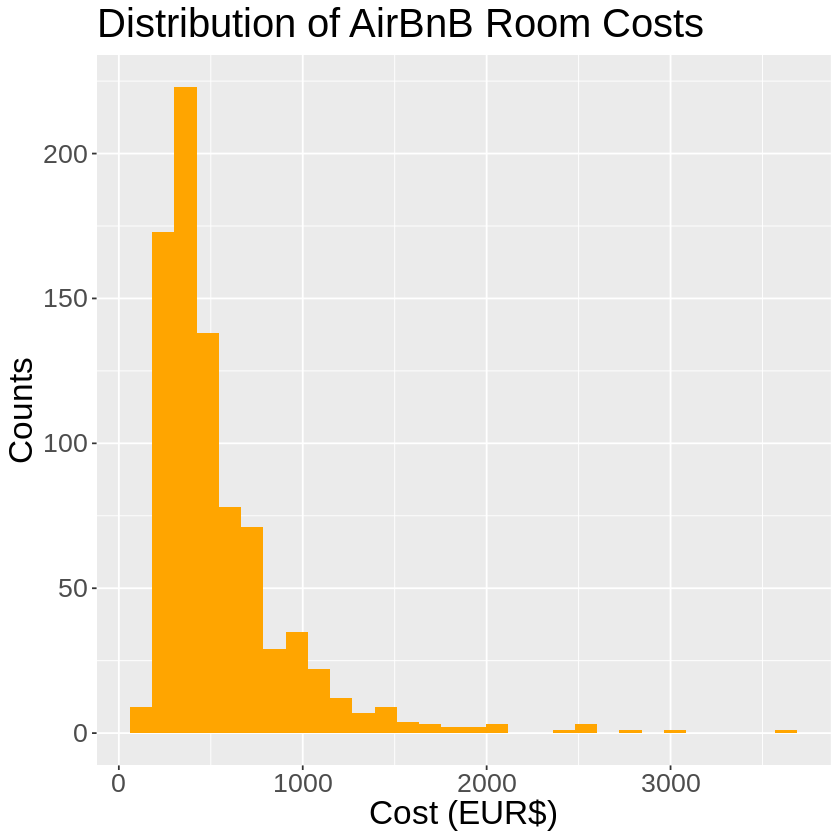

In [23]:
ggplot(amsterdam_weekdays_training, aes(x=cost)) +
    geom_histogram(fill="orange") +
    labs(x="Cost (EUR$)", y="Counts", title="Distribution of AirBnB Room Costs") +
    theme(text = element_text(size = 20))
    

The distribution of the costs is skewed with a heavy right tail.

## Methods
(Explain how you will conduct either your data analysis and which variables/columns you will use)
- Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?

(Describe at least one way that you will visualize the results)

## Expected outcomes and significance:
### What do you expect to find?
TBD
### What impact could such findings have?
TBD
### What future questions could this lead to?
TBD